In [1]:
import os
import json
import time
#import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import scipy.signal as signal
import h5py
import pickle
#from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

import pygama.lgdo.lh5_store as lh5
#from pygama.dsp import build_dsp
#from pygama.dsp.processors.linear_slope_fit import linear_slope_fit
#from pygama.dsp.processors.bl_subtract import bl_subtract

from multihist import Hist1d, Histdd
from datetime import datetime, timezone
from legendmeta import LegendMetadata
meta_path = '/data1/users/dandrea/software/legend-metadata'
lmeta = LegendMetadata(path=meta_path)
chmap = lmeta.hardware.configuration.channelmaps.on("20230310T175624Z")

import pulser_analysis as pa
import analysis_utility as au

%load_ext autoreload
%autoreload 2

In [ ]:
"""run = 20
test_file = f'r{run:03}/pulser_test/test_pulser.txt'
test_dict_file = f'r{run:03}/pulser_test/test_pulser.json'
with open(test_file,'r') as datafile:
    test_file = f'r{run:03}/pulser_test/test_pulser.txt'
    n_test = int(len(datafile.read().split())/5)
test_dict = {}
test_dict['test1'] = {}
for i in range(n_test):
    with open(test_file,'r') as datafile:
        temp = datafile.read().split()[i*5:(i+1)*5]
    ene, att, rate, ttime, key = temp
    key_list = [key]
    test_dict['test1'][i] = {'energy':float(ene),'attenuation':int(att),'rate':float(rate),'time':int(ttime),'key_list':key_list}
with open(test_dict_file,'w') as f:
    json.dump(test_dict, f, indent=4)"""

In [13]:
run = 20
par_dir = '/data1/users/marshall/prod-ref/v06.00/generated/par'
dsp_config = f'{par_dir}/dsp/cal/p02/r020/l200-p02-r020-cal-20230307T151732Z-par_dsp.json'
hit_config = f'{par_dir}/hit/cal/p02/r020/l200-p02-r020-cal-20230307T151732Z-par_hit.json'
ge_all = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds']
ge_off = ['V07298B', 'P00665A', 'V01386A', 'V01403A', 'V01404A', 'B00091D', 'P00537A', 'B00091B', 'P00538B', 'P00661A', 'P00665B', 'P00698B']
ge_drift = ['V01406A', 'V01415A', 'V01387A', 'P00665C','P00748B', 'P00748A']
ge_keys = [ch for ch in ge_all if ch not in ge_off]
ge_keys = [ch for ch in ge_keys if ch not in ge_drift]
ge_rawid = [chmap[ch]['daq']['rawid']  for ch in ge_keys]
ge_table = [f'ch{id}' for id in ge_rawid]
#chn_off = (26,33,46,47,48,50,84,85,94,112,116,117,120,122)
#chn_off = (26,33,46,47,48,50,84,85,94,105,112,116,117,120,122)
ge_numbers = [chmap[ch]['daq']['fcid'] for ch in ge_keys]
chns = [f'ch{n:03}' for n in ge_numbers]
nn = len(ge_table)
puls = [ch for ch in chmap.keys() if chmap[ch]['system']=='puls']
puls_rawid = [chmap[ch]['daq']['rawid']  for ch in puls]
puls_table = [f'ch{id}' for id in puls_rawid]
raw_dir = f'/data1/users/dandrea/test_data/raw/r{run:03}_pulser_test'
daq_dir = f'/data1/users/dandrea/test_data/daq/r{run:03}_pulser_test'
test_dict_file = f'r{run:03}/pulser_test/test_pulser.json'
with open(test_dict_file,'r') as file:
    test_dict = json.load(file)

In [10]:
ge_string = [chmap[ch]['location']['string'] for ch in ge_keys]
ge_loc = [chmap[ch]['location']['position'] for ch in ge_keys]

In [17]:
n_test, n_acq = 1, 0
this_dict = test_dict[f'test{n_test}'][f'{n_acq}']
key_list = [f'l200-p02-r{run:03}-tst-{key}' for key in this_dict['key_list']]
raw_list = [f'{raw_dir}/l200-p02-r{run:03}-tst-{key}_raw.lh5' for key in this_dict['key_list']]

In [ ]:
au.daq_convertion(daq_dir, key_list[0], stream_type = 'ORCA', raw_dir = raw_dir)

In [ ]:
pa.plot_pulser_waveforms(puls_table[1], 'pulser', raw_list[0], nwf = 100, apply_mask = 1, xlim=(3060,3075))#xlim=(3046,3061))

In [ ]:
pa.plot_pulser_fft(ge_table[:9], ge_keys[:9], raw_list[0], nwf = 100, apply_mask = 1,ylim=(3e4,3e7))

In [ ]:
pa.pulser_waveform(raw_list[:], chmap, dsp_config, hit_config, test_dict_file, n_test=n_test, n_acq=n_acq,
                   wcut=2100, sconv=200, nstring=None)#, plot_dir='r017/pulser_test')

In [ ]:
pa.pulser_dsp_analysis(run, chmap, test_dict_file, n_test=1,n_acq=5, nstring=None, plot_dir='r020/pulser_test/plots')

In [75]:
def plot_pulser_info(chmap, test_dict, n_test = 1, nstring = None, plot_dir = None):
    with open(test_dict_file,'r') as file:
        test_dict = json.load(file)
    acquistions = [k for k in test_dict[f'test{n_test}'].keys()][:]
    print(acquistions)
    fig, axis = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    fig0, axis0 = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    fig1, axis1 = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    fig2, axis2 = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    fig3, axis3 = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    strings = np.array([int(chmap[ch]['location']['string']) for ch in chmap.keys() if chmap[ch]['system']=='geds'])
    if nstring is None: nstring = strings.max()
    for string in range(1,nstring+1):
        ax, ax0 = axis.flat[string-1], axis0.flat[string-1]
        ax1, ax2, ax3 = axis1.flat[string-1], axis2.flat[string-1], axis3.flat[string-1]
        
        ge_keys = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds' and chmap[ch]['location']['string']==string]
        ge_numbers = [chmap[ch]['daq']['fcid'] for ch in ge_keys]
        ge_keys = [ch for ch in ge_keys if ch not in ge_off]
        ge_keys = [ch for ch in ge_keys if ch not in ge_drift]
        ge_rawid = [chmap[ch]['daq']['rawid']  for ch in ge_keys]
        ge_table = [f'ch{id}' for id in ge_rawid]
        cc4s = [chmap[ch]['electronics']['cc4']['id'] for ch in ge_keys]
        
        energy = [float(test_dict[f'test{n_test}'][f'{n_acq}']['energy'])*1000 for n_acq in acquistions]
        
        for i, chn in enumerate(ge_table[:]):
            if ge_keys[i] == 'B00089D': continue
            try:
                fwhm = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['fwhm'] for n_acq in acquistions]
                fwhm_err = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['fwhm_err'] for n_acq in acquistions]
                pos = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['position'] for n_acq in acquistions]
                ax.errorbar(acquistions, fwhm,yerr=fwhm_err,marker='o', label=f'{ge_keys[i]}-{cc4s[i]}')
                ax0.plot(acquistions, pos,'o-',label=f'{ge_keys[i]}-{cc4s[i]}')
                acqs = [['0','4','8'], ['1','3','5','7'], ['2','6']]
                for j, a in enumerate(acqs):
                    if j == 0: axx, ene = ax1, '1 MeV'
                    if j == 1: axx, ene = ax2, '2 MeV'
                    if j == 2: axx, ene = ax3, '3 MeV'
                    pos = np.array([test_dict[f'test{n_test}'][f'{n_acq}'][chn]['position'] for n_acq in a])
                    pos = (pos-pos.mean())/pos.mean()*100
                    axx.plot(a, pos,'o-', label=f'{ge_keys[i]}-{cc4s[i]}')
                    axx.axhline(0,color='k',ls=':')
                    axx.set_ylim(-0.02,0.02)
                    if j == 0: axx.set_xlim(-1.3,2.1)
                    if j == 1: axx.set_xlim(-1.8,3.1)
                    if j == 2: axx.set_xlim(-0.7,1.1)
                    axx.set_xlabel('n. acquistion')
                    axx.set_ylabel('realtive shift (%)')
                    axx.legend(title=f'String {string} - ampl = {ene}',loc='upper left')
            except: pass
        ax.legend(title=f'String {string}',loc='upper left')
        ax.set_xlabel('n. acquistion')
        ax.set_ylabel('FWHM (keV)')
        ax0.legend(title=f'String {string}',loc='upper left')
        ax0.set_xlabel('n. acquistion')
        ax0.set_ylabel('pulser position (keV)')
        
    if plot_dir is not None:
        fig0.savefig(f'{plot_dir}/test{n_test}_fwhm_all.png',dpi=300, bbox_inches='tight')
        fig1.savefig(f'{plot_dir}/test{n_test}_position_all.png',dpi=300, bbox_inches='tight')

['0', '1', '2', '3', '4', '5', '6', '7', '8']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


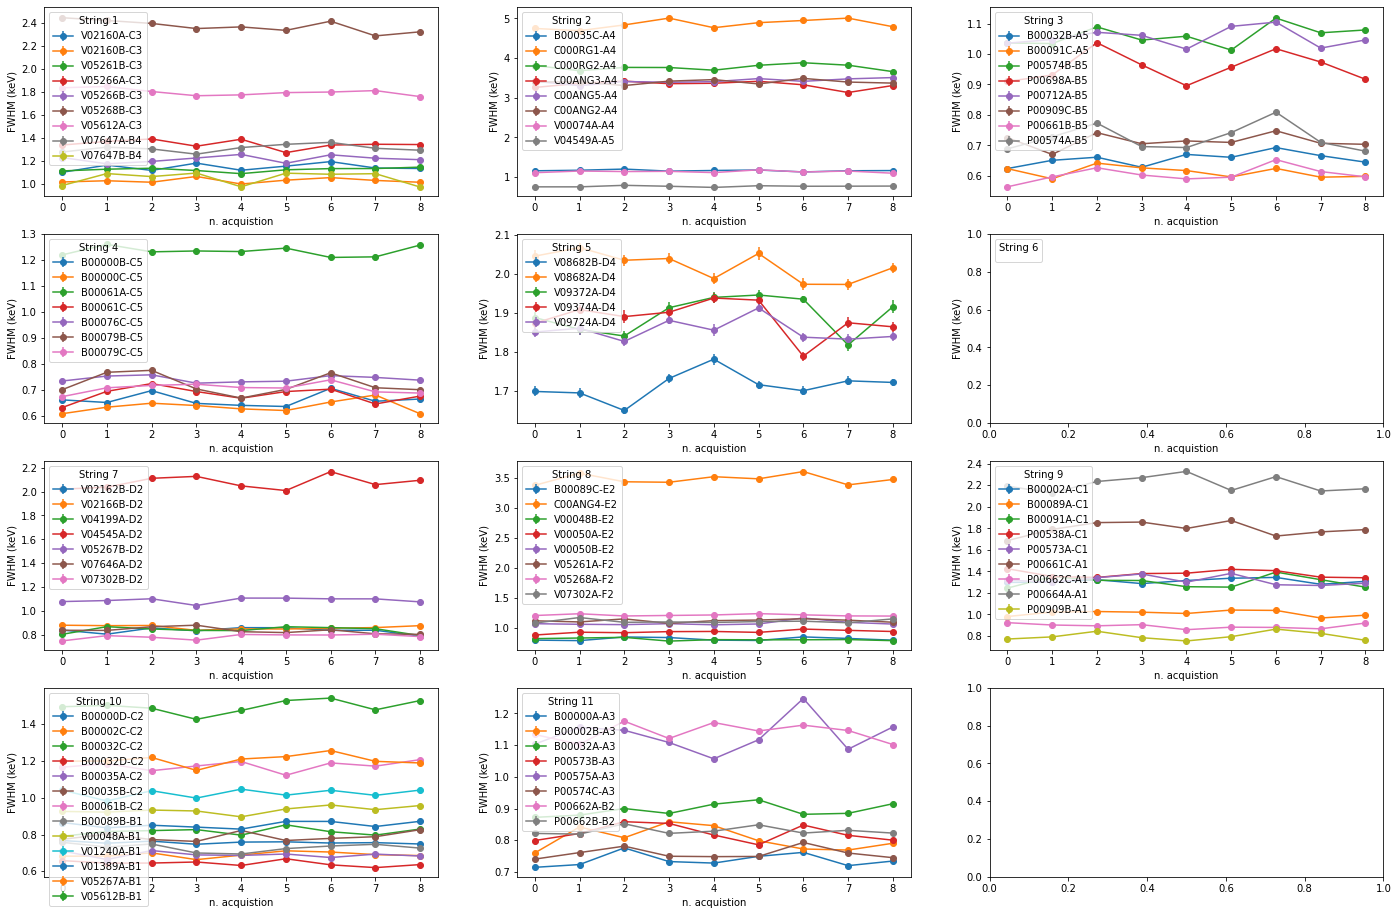

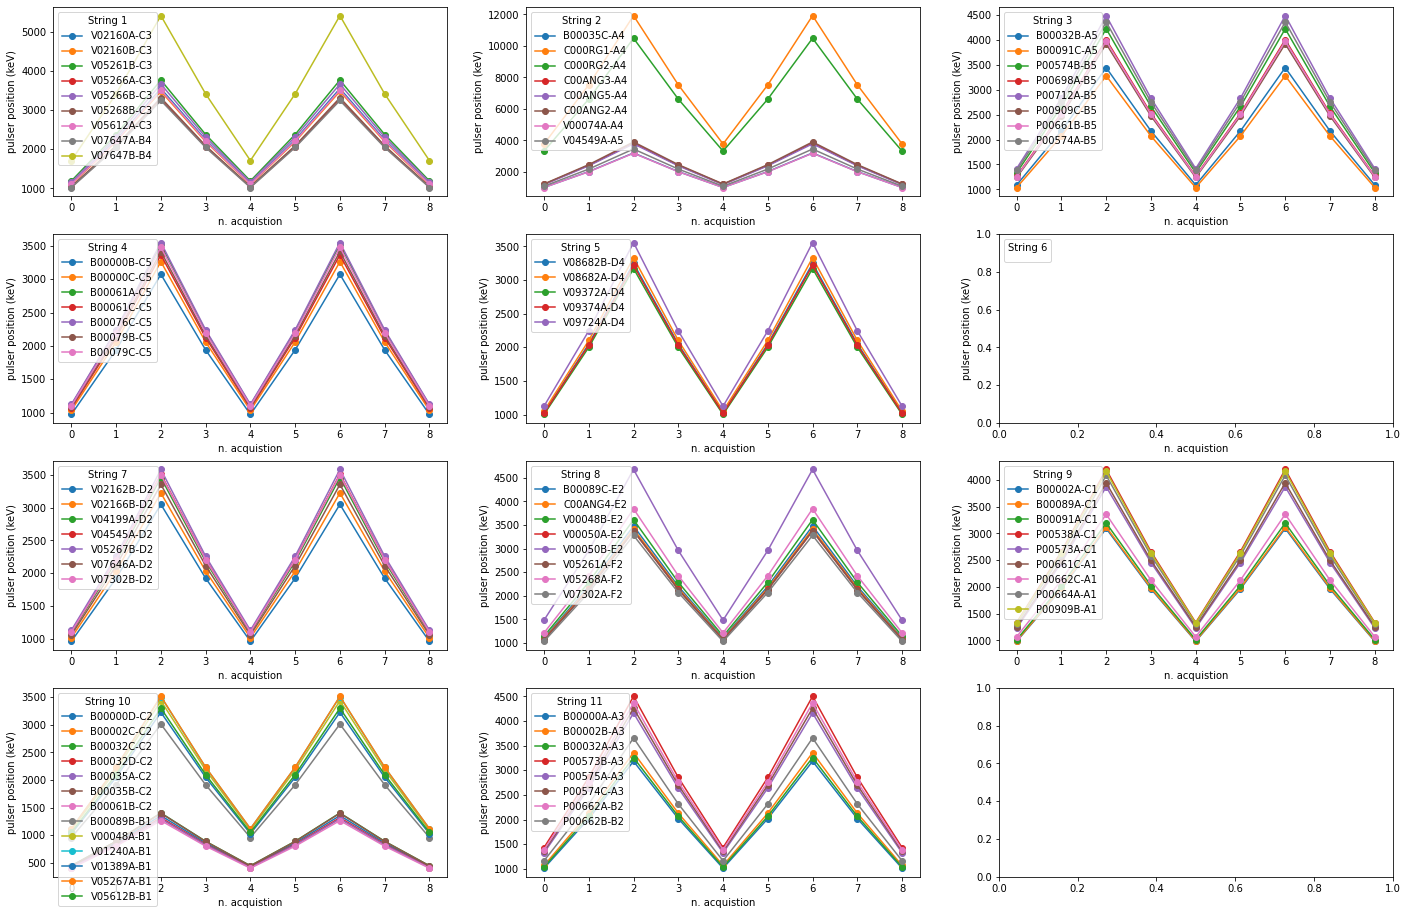

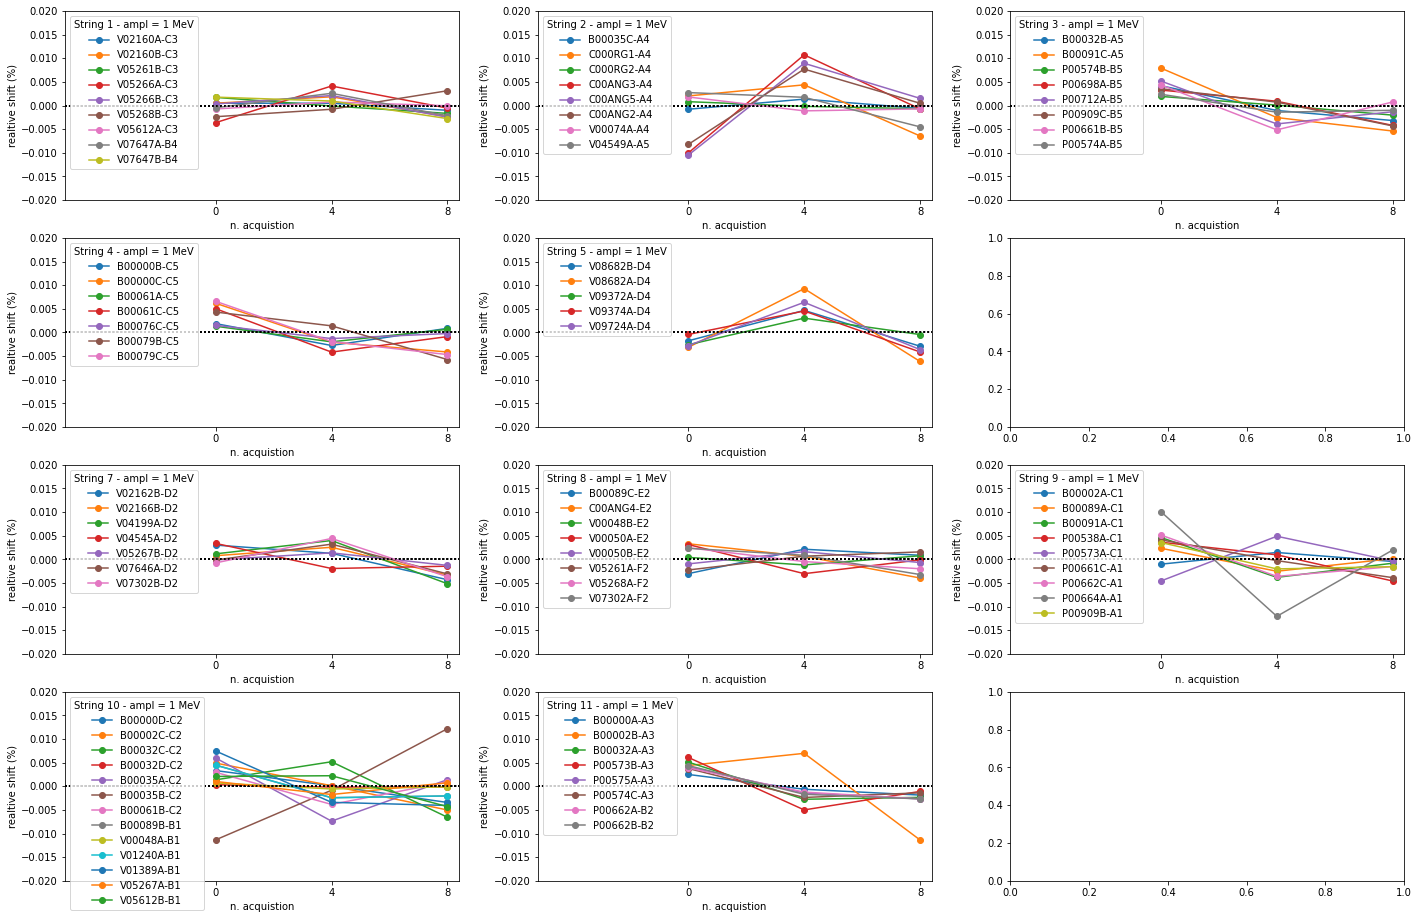

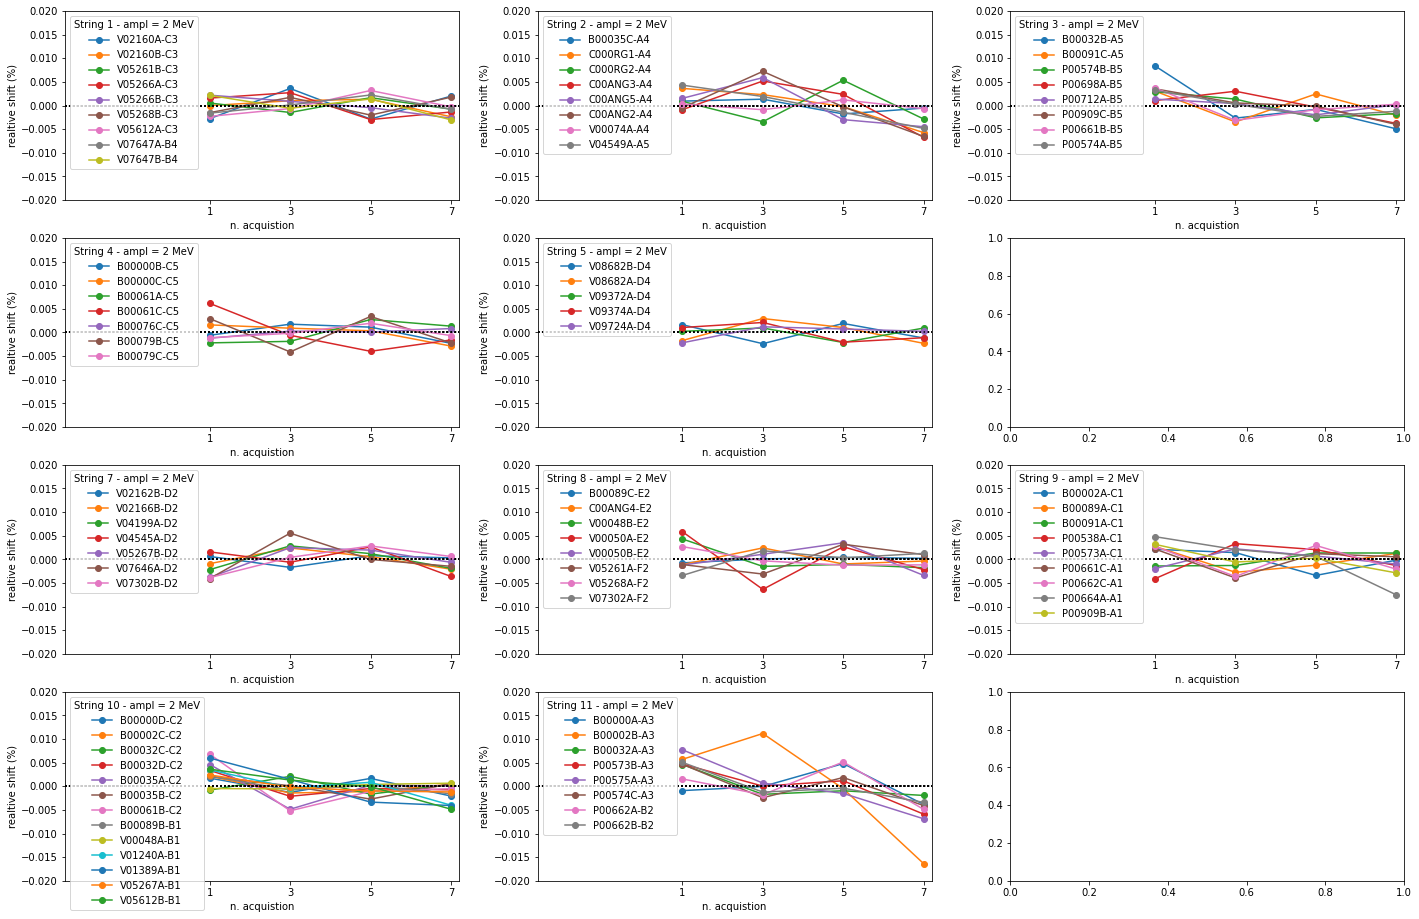

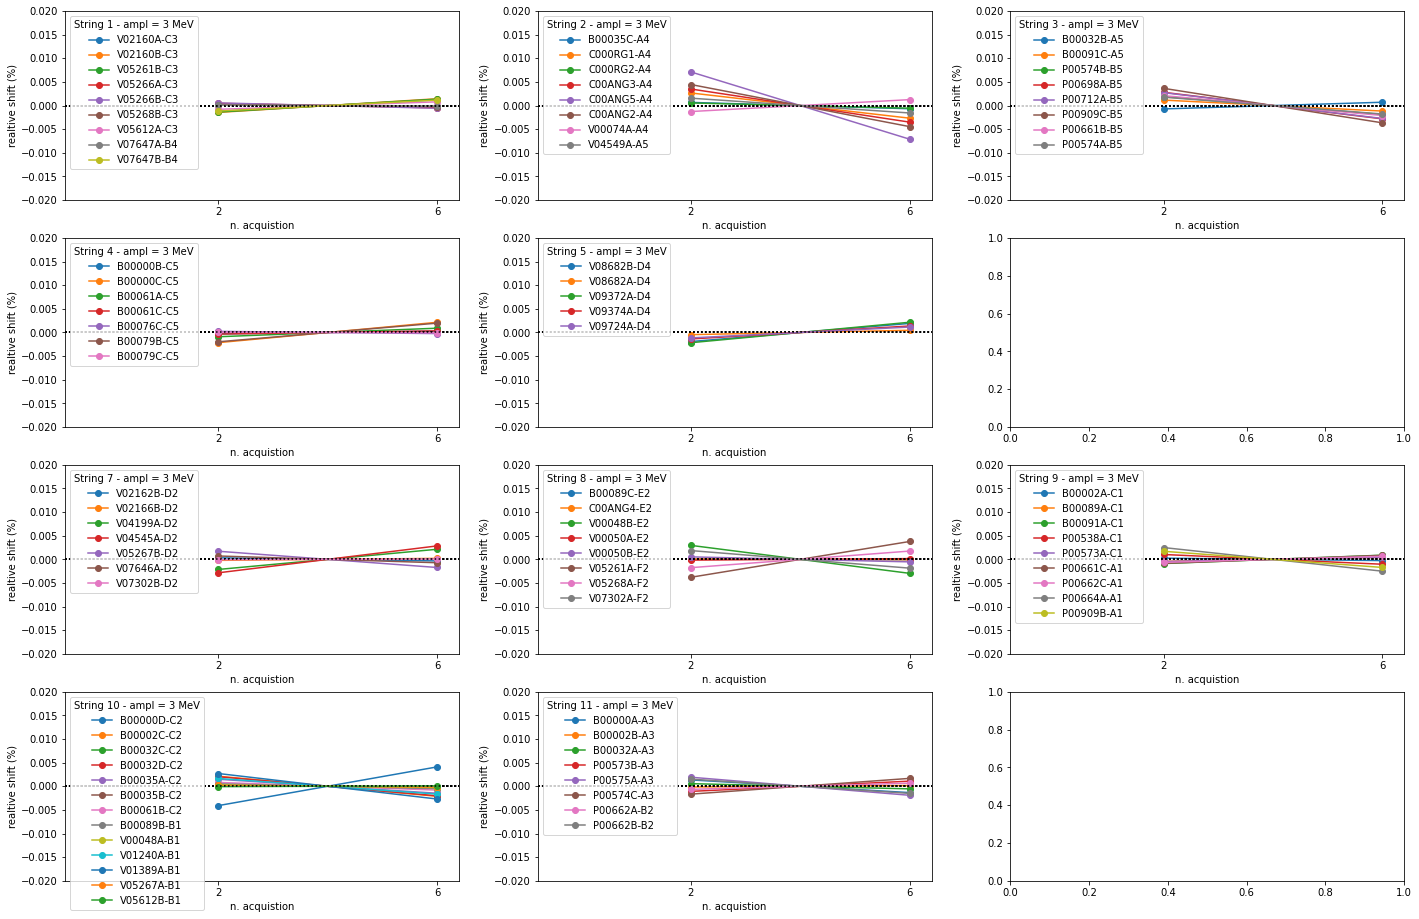

In [76]:
plot_pulser_info(chmap, test_dict, n_test=1, nstring = None, plot_dir = 'r020/pulser_test/plots')